In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, Normalizer
from category_encoders import BinaryEncoder
from sklearn.compose import  ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [2]:
house_data = pd.read_csv('./1/data.csv')

In [3]:
house_data.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
#ignoring date for this task
house_data.drop(['date'],axis=1,inplace=True)

In [5]:
house_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country'],
      dtype='object')

In [6]:
house_data.dtypes

price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

In [7]:
#Dropping rows with invalid price i.e 0
house_data = house_data[house_data.price!=0]

In [8]:
# Making bathroms, bedrooms and floors integers
house_data.floors = house_data.floors.astype(int)
house_data.bedrooms = house_data.bedrooms.astype(int)
house_data.bathrooms = house_data.bathrooms.astype(int)

In [9]:
# Continous variables
continous_cols = house_data.select_dtypes(include=[np.number])


# Categorical variables
categorical_cols = house_data.select_dtypes(include="object")


print('Continous variables:')
print(continous_cols.columns)
print('Categorical variables:')
print(categorical_cols.columns)

Continous variables:
Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated'],
      dtype='object')
Categorical variables:
Index(['street', 'city', 'statezip', 'country'], dtype='object')


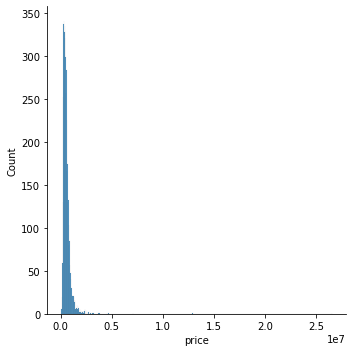

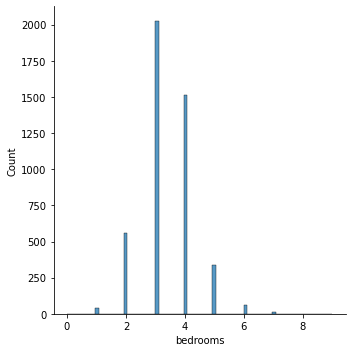

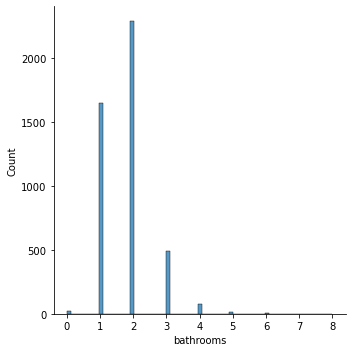

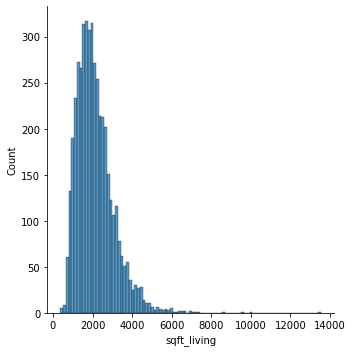

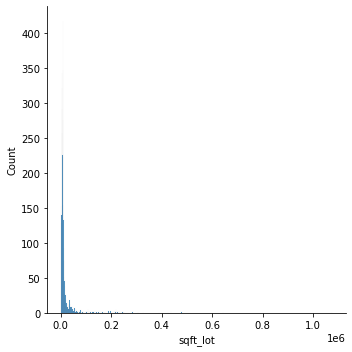

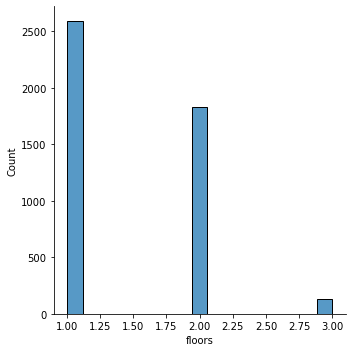

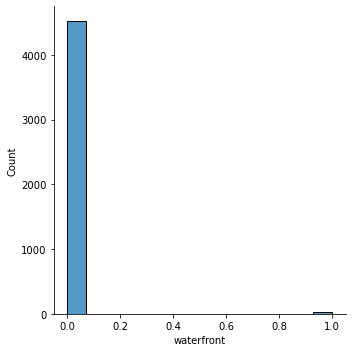

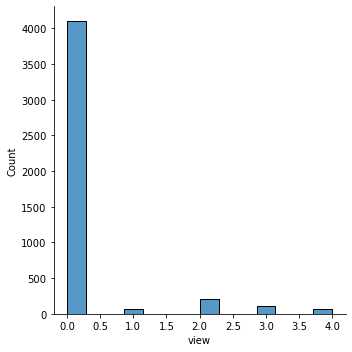

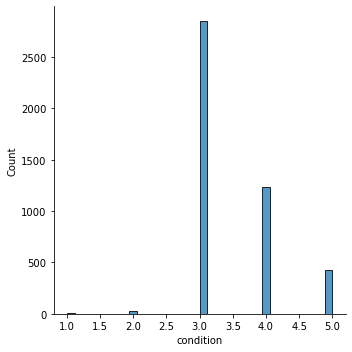

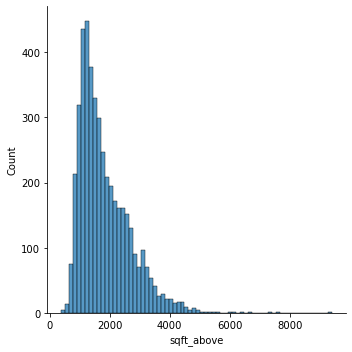

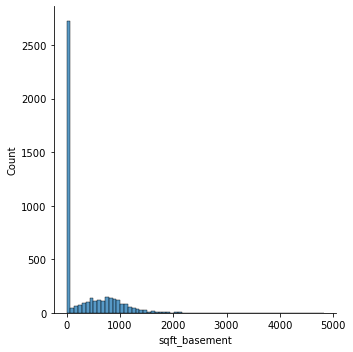

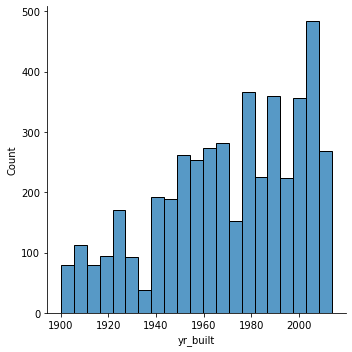

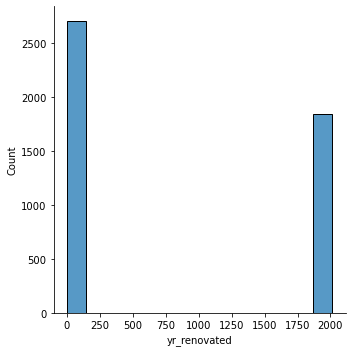

In [10]:
#Univariate distribution for continous variable
for col in continous_cols:
        sns.displot(house_data[col])


In [11]:
# All the features seem to be in varying scales. For examples sqft_lot and bedrooms are have a huge gap in their values.
# Scaling these features might help to better predict price.

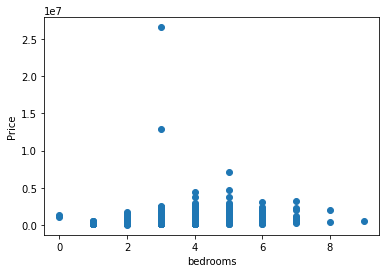

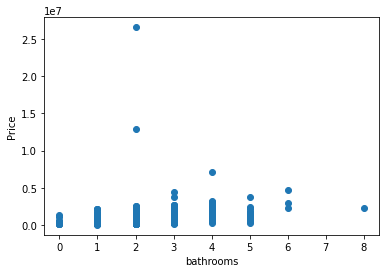

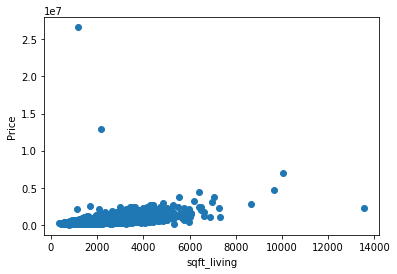

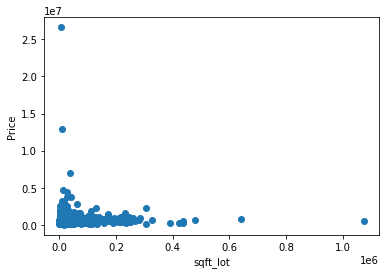

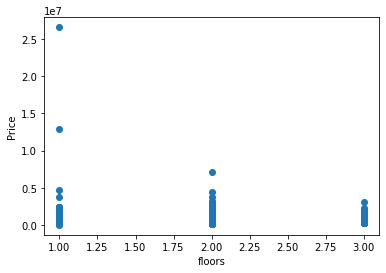

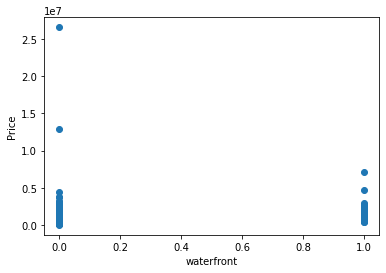

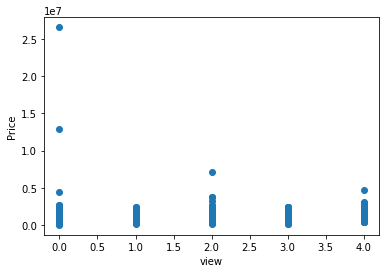

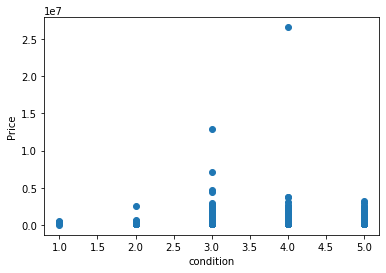

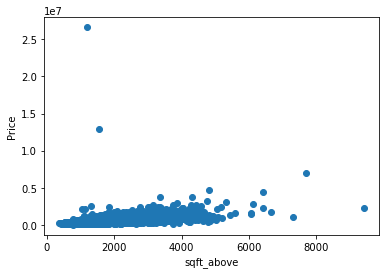

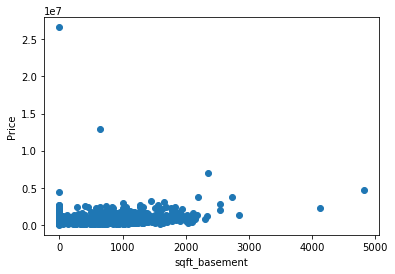

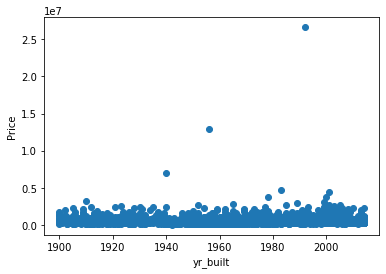

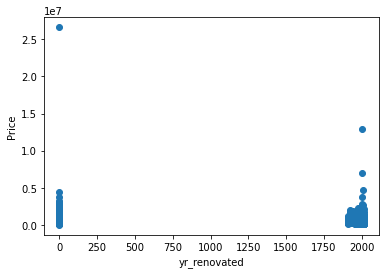

In [12]:
# 2D Scatter plots for continuous features with the target
for col in np.array(continous_cols.columns)[1:]:
    fig, axis = plt.subplots()
    axis.set_xlabel(col)
    axis.set_ylabel('Price')
    axis.scatter(house_data[col], house_data.price)

In [13]:
for col in house_data.select_dtypes(include=['object']):
    print("No. of uniq values for {}".format(col), house_data[col].nunique())
    print('===================================')

No. of uniq values for street 4476
No. of uniq values for city 44
No. of uniq values for statezip 77
No. of uniq values for country 1


In [14]:
#No missing values
house_data.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [15]:
#Since street has many unique values encoding it wont really add any info to the model, so its better to drop it.
#And country is the same value for all rows so we can drop country as well
house_data_features = house_data.drop(['price','street','country'],axis=1)

In [16]:
# Without Scaler
ct = ColumnTransformer(
    [("onehot", OneHotEncoder(), ['city'])])

In [17]:
ct2 = ColumnTransformer(
    [("onehot", OneHotEncoder(), ['city']),("scaling", StandardScaler(), continous_cols.columns[1:])])

In [18]:
le = LabelEncoder()
house_data_features.statezip = le.fit_transform(house_data_features.statezip)

In [19]:
def transform_predict(model, transformer=None):
    #Splitting the data to train and test
    X_train, X_test, y_train, y_test = train_test_split(transformer.fit_transform(house_data_features) if transformer else house_data_features, house_data.price, test_size=0.25, random_state=42)
    model.fit(X_train,y_train)
#     print(X_train.shape)
    return model.score(X_test,y_test)

In [20]:
linreg = LinearRegression()
print('Without Scaling: {}'.format(transform_predict(linreg,ct)))
print('With StandardScaler: {}'.format(transform_predict(linreg,ct2)))

Without Scaling: 0.2384748023125135
With StandardScaler: 0.6845414298113417


In [21]:
ridge = RidgeCV()
print('Without Scaling: {}'.format(transform_predict(ridge,ct)))
print('With StandardScaler: {}'.format(transform_predict(ridge,ct2)))

Without Scaling: 0.23770296468335583
With StandardScaler: 0.6868108950567084


In [22]:
lasso = LassoCV()
print('Without Scaling: {}'.format(transform_predict(lasso,ct)))
print('With StandardScaler: {}'.format(transform_predict(lasso,ct2)))

Without Scaling: 0.2394668702085736
With StandardScaler: 0.6897811060438012


In [23]:
elasticnet = ElasticNetCV(cv=20)
print('Without Scaling: {}'.format(transform_predict(elasticnet,ct)))
print('With StandardScaler: {}'.format(transform_predict(elasticnet,ct2)))

Without Scaling: 0.0007708696699677553
With StandardScaler: 0.01326171793016473


In [24]:
# 2 Question

In [25]:
from sklearn.datasets import fetch_openml

In [26]:
credit_data, y = fetch_openml('credit-g',return_X_y=True)

In [27]:
credit_data.dtypes

checking_status           category
duration                   float64
credit_history            category
purpose                   category
credit_amount              float64
savings_status            category
employment                category
installment_commitment     float64
personal_status           category
other_parties             category
residence_since            float64
property_magnitude        category
age                        float64
other_payment_plans       category
housing                   category
existing_credits           float64
job                       category
num_dependents             float64
own_telephone             category
foreign_worker            category
dtype: object

In [28]:
categorical_cols = credit_data.select_dtypes(include='category')

continous_cols = credit_data.select_dtypes(include=[np.number])

print('Categorical columns:',categorical_cols.columns)
print('Continous columns:',continous_cols.columns)

Categorical columns: Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker'],
      dtype='object')
Continous columns: Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents'],
      dtype='object')


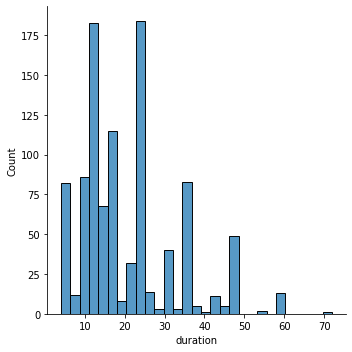

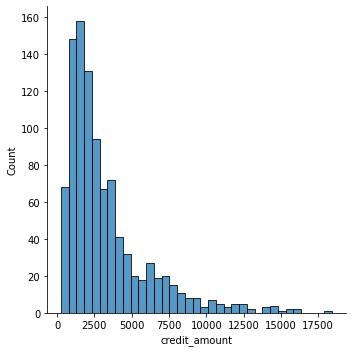

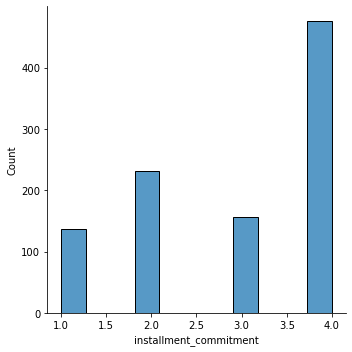

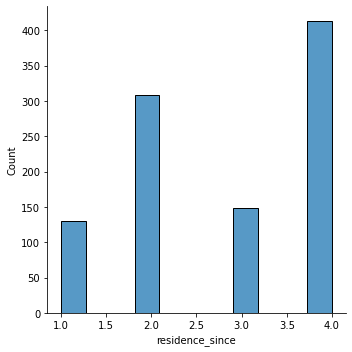

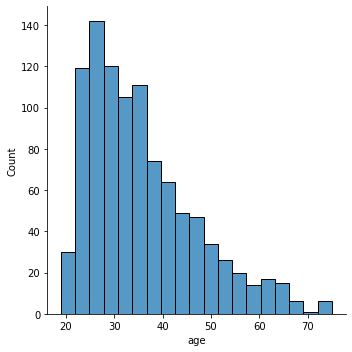

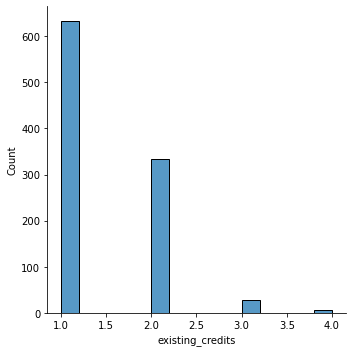

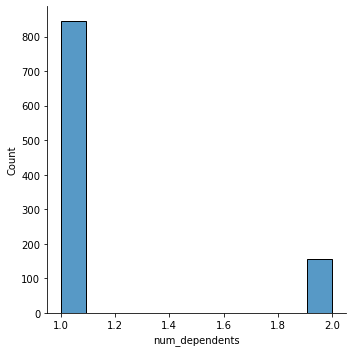

In [29]:
#Univariate distribution of continous variables
for col in continous_cols:
    sns.displot(credit_data[col])

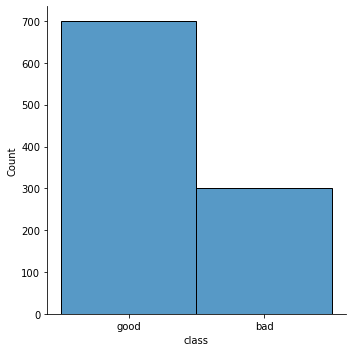

In [30]:
#Distribution of target variable
sns.displot(y)

In [31]:
for col in categorical_cols:
    print('Number of unique values for {}: {}'.format(col,credit_data[col].nunique()))
    print('==================================')

Number of unique values for checking_status: 4
Number of unique values for credit_history: 5
Number of unique values for purpose: 10
Number of unique values for savings_status: 5
Number of unique values for employment: 5
Number of unique values for personal_status: 4
Number of unique values for other_parties: 3
Number of unique values for property_magnitude: 4
Number of unique values for other_payment_plans: 3
Number of unique values for housing: 3
Number of unique values for job: 4
Number of unique values for own_telephone: 2
Number of unique values for foreign_worker: 2


In [32]:
X_train, X_test, y_train, y_test = train_test_split(credit_data,y,test_size=0.3,random_state=42) 

In [33]:
ct3 = ColumnTransformer([
    ('onehot',OneHotEncoder(sparse=False),categorical_cols.columns)
])

In [34]:
ct4 = ColumnTransformer([
    ('scaler1',StandardScaler(),continous_cols.columns),
    ('onehot',OneHotEncoder(sparse=False),categorical_cols.columns)
])

In [35]:
def transform_predict2(model,transformer=None):
    X_train_trans = transformer.fit_transform(X_train) if transformer else X_train
    model.fit(X_train_trans,y_train)
    X_test_trans = transformer.fit_transform(X_test) if transformer else X_test
    return model.score(X_test_trans,y_test)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
models = [LogisticRegression(), KNeighborsClassifier(),SVC()]
for model in models:
    print(model)
    print('Without Scaling:{}'.format(transform_predict2(model,ct3)))
    print('With Standard Scaler:{}'.format(transform_predict2(model,ct4)))
    print('========================')

LogisticRegression()
Without Scaling:0.7466666666666667
With Standard Scaler:0.7766666666666666
KNeighborsClassifier()
Without Scaling:0.7033333333333334
With Standard Scaler:0.74
SVC()
Without Scaling:0.7133333333333334
With Standard Scaler:0.7633333333333333


In [37]:
#There is a significant increase in the r2 score after using a standard scaler.

In [38]:
# 3 Question

In [39]:
import random
from random import randint
from sklearn.metrics import log_loss

In [40]:
#Generating a random line ax+by+c
random.seed(30)
l = [randint(-100,100),randint(-100,100),randint(-100,100)]

In [41]:
X = np.random.randint(-10,10,size=(500,2)) #Generating 500 random (x,y) points
Y = np.where(np.dot(X,l[:-1])+l[-1]>0,1,-1) # Mapping the points to -1 or 1 

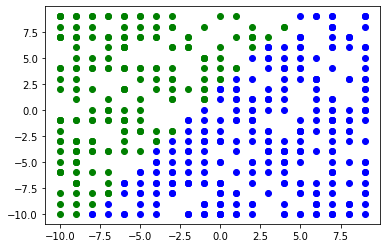

In [42]:
#This code has been taken from video titled 'How to Generate Synthetic Linearly Separable Data Points : MatplotLib Tutorials # 2'
# https://www.youtube.com/watch?v=QX3Sn6EGA7U
def plot_points(X,l):
    for i in range(len(X)):
        if np.dot(X[i],l[:-1])+l[-1]>0:
            plt.scatter(X[i][0],X[i][1],c='b')
        else:
            plt.scatter(X[i][0],X[i][1],c='g')
    plt.show()
plot_points(X,l)

In [43]:
def learning_function(X,Y):
    w_initial = w = (np.random.randint(-100,100, size=(3,)))
    pred = np.dot(X,w[:-1])+w[-1]
    loss = log_loss(Y,pred)
    for row in X:
        i = randint(0,499) #Picking a random sample from the 500 points
        s = np.dot(X[i],w[:-1])+w[-1]
        y = 1 if s > 0 else -1
        if  y==Y[i]:
            continue
        else:
            w = np.append(w[:-1]+np.dot(Y[i],X[i]),w[-1])
        pred = np.dot(X,w[:-1])+w[-1]
        loss = log_loss(Y,pred)
    return (w)

In [44]:
w = (learning_function(X,Y))
print(w)
print("Actual Line coefficients:",l)

[ 43 -27  62]
Actual Line coefficients: [38, -26, 56]


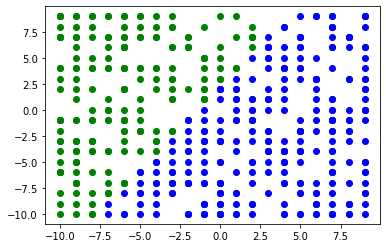

In [45]:
plot_points(X,w) #With updated weights

In [46]:
# 4th Question

In [47]:
data = []
with open('4/iris.data','r') as f:
    for line in f.readlines():
        if line!='\n':
            data.append(line.strip().replace('\n','').split(','))

In [48]:
iris_df = pd.DataFrame(data,columns=['sepal_length','sepal_width','petal_length','petal_width','class'])

In [49]:
iris_df.sepal_length = iris_df.sepal_length.astype(float)
iris_df.sepal_width = iris_df.sepal_width.astype(float)
iris_df.petal_length = iris_df.petal_length.astype(float)
iris_df.petal_width = iris_df.petal_width.astype(float)

In [50]:
le = LabelEncoder()
y_trans = le.fit_transform(iris_df['class'])

In [51]:
X_train,X_test,y_train,y_test = train_test_split(iris_df.drop('class',axis=1).values,y_trans,test_size=0.25,random_state=42)

In [52]:
import math
from scipy.stats import mode
import heapq

In [53]:
def distance(a, b):
    return math.sqrt(sum([(a[i]-b[i])**2 for i in range(len(a))]))
        

In [54]:
def get_nearest_neighbor_predictions(train_data,targets,test_example,k=3):
    heap = []
    for i in range(len(train_data)):
        heapq.heappush(heap, (-distance(train_data[i], test_example),i))
    for i in range(len(train_data)-k):
        heapq.heappop(heap)                    #Removing farthest points until k points are left in the heap 
    return list(map(lambda x:targets[x[1]],heap))

In [55]:
from scipy.stats import mode
def KNN(X_train,X_test,y_train):
    Y_preds = []
    for test_row in X_test:
        preds = get_nearest_neighbor_predictions(X_train,y_train,test_row)
        Y_preds.append(mode(preds).mode[0])
    return Y_preds

In [56]:
preds = KNN(X_train,X_test,y_train)

In [57]:
from sklearn.metrics import precision_score

In [58]:
#Precision on test data is 1
precision_score(y_test,preds,average='macro')

1.0

In [59]:
#Time complexity using a heap would be O(n*d) +O((n-k)*log(k)) 
# 'n' is number of examples
# 'd' is number of dimensions
# 'k' is number of neighbors